# Supervised learning applied to transaction approval

by Giancarlo Marchesi

This notebook contains the analysis for a series of credit scoring models for a small direct account payment gateway company.

A payment gateway is a merchant service provided by an e-commerce application company that authorizes credit card or direct payments processing for e-businesses, online retailers, bricks and clicks, or traditional brick and mortar. This particular gateway company authorizes direct payments to merchants from customers' bank accounts. The gateway has no online connection to banks, so it must rely on its own scoring models to determine which customers to approve. Bad transactions occur when customers do not have funds in their accounts at the time. Merchants get paid immediately, so default risk stays with the gateway company.

The company currently has access to scores from two credit rating providers, yet still uses a manual process to approve the transactions. Unless they get specific confirmation by phone from the customer's bank that the customer's account is empty, the transaction is approved. Hence, they are not leveraging the data from the providers. Bad (insolvent) transactions are frequent. The client wants to know how to use the data they have effectively to have a better risk model and be more profitable. The sector in which the company operates is risky. The commerces do not take credit cards, only direct payments. Commerces that use these methods generally attract riskier clients.  

## Objective

The objective of the project is to help the company maximize profits by approving the most amount of good transactions and limiting the bad ones. The business loses 100% of bad transactions and charges 5% of good transactions.

The analysis presents alternative credit scoring models using supervised machine learning methods that combine these scores and other available data. The data is from a private direct payment processing company. Only features pertaining to the analysis are shown in the dataset. 

**Model alternatives:**
- Use only independent `score 1` as is
- Use only independend `score 2` as is
- Use an interaction of scores 1 and 2 (two versions)
- Use a logistic regression model 
- Use a KNN model  

The working hypothesis is that both ML models will provide additional insight to the independent scores. 

## Exploring the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('data_final_2.csv', sep=";")

In [3]:
df.head()

,score_1,risk_score1,score_2,risk_score2,interaction_1,interaction_2,transaction,bad_transaction,state,population,sc_control
0,excellent,0,medium,1,0,1,79,0,NV,0,0
1,excellent,0,excellent,0,0,0,99,0,MD,0,0
2,excellent,0,medium,1,0,1,50,0,OH,0,0
3,excellent,0,excellent,0,0,0,79,0,FL,1,0
4,good,0,excellent,0,0,0,99,0,IN,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   score_1          824 non-null    object
 1   risk_score1      824 non-null    int64 
 2   score_2          824 non-null    object
 3   risk_score2      824 non-null    int64 
 4   interaction_1    824 non-null    int64 
 5   interaction_2    824 non-null    int64 
 6   transaction      824 non-null    int64 
 7   bad_transaction  824 non-null    int64 
 8   state            823 non-null    object
 9   population       824 non-null    int64 
 10  sc_control       824 non-null    int64 
dtypes: int64(8), object(3)
memory usage: 70.9+ KB


In [5]:
df.shape

(824, 11)

The dataset contains 824 observations and 11 features. 

### Feature description

- `score_1`: client risk category depending on score from provider 1. Five possible categories: excellent, good, medium, bad  and no data (nd)
- `risk_score1`: binary variable according to risk profile from provider 1. Excellent and good are assigned a score of 0. The rest of the categories get a score of 1. 
- `score_2`:  client risk category depending on score from provider 2. Five possible categories: excellent, good, medium, bad  and no data (nd)
- `risk_score2`: binary variable according to risk profile from provider 2. Excellent and good are assigned a score of 0. The rest of the categories get a score of 1. 
- `interaction_1`: interaction term between score_1 and score_2. If both have a score of 1, the variable will be 1, i.e a risky client. In other cases, the variable will be 0.  Risk is considered as combinations of medium, bad or no data. 
- `interaction_2`: its a more stringent definition of risk. Only the combinations of excellent, excellent and good,excellent in both permutations are considered 0. The rest are considered 1 (i.e risky). 
- `transaction`: es is the dollar amount of the transaction
- `bad_transaction`: binary variable where 1 corresponds to a bounced transaction (bad electronic check) and 0 is a succesful transaction (i.e the customer had the necessary funds). 
- `state`: two letters corresponding to the state in the United States
- `population`: binary variable where 1 is assigned to the most populous states: California, Texas, Florida, New York y Pennsylvania 
- `sc_control`: binary variable where 1 is assigned to the state of South Carolina. It has a disproportionate amount of transactions in the dataset for the size of its population. 


## Exploring the data

In [6]:
## How many transactions are considered risky by the first score?
df.risk_score1.sum()

126

In [7]:
## How many transactions are considered risky by the second score?
df.risk_score2.sum()

179

In [8]:
## How many transactions were actually bad?
df.bad_transaction.sum()

153

In [9]:
## What percentage of transactions are bad? 
153/824

0.18567961165048544

In [10]:
## How many transactions are considered risky by the first interaction term?
df.interaction_1.sum()

42

In [11]:
## How many transactions are considered risky by the second interaction term?
df.interaction_2.sum()

323

In [12]:
## The average size of a transaction in USD
df.transaction.mean()

74.88106796116504

In [13]:
df[df['bad_transaction']==0]['transaction'].mean()

74.23248882265275

In [14]:
df[df['bad_transaction']==1]['transaction'].mean()

77.72549019607843

- The dataset has 824 observations, so it is relatively small. 

- The number of bad transactions is 153 (18.56%). So the company's problem is serious. On the positive side for the analysis, we are not facing an unbalanced sample. 
    
- Average dollar amount per transaction: 
    - Good transactions: 74.23
    - Bad transactions:  77.73

## The business problem

In [15]:
## Money lost
lost=df['bad_transaction']*df['transaction']
lost.sum()

11892

In [16]:
## Money made
made=0.05*(df[df['bad_transaction']==0]['transaction'].sum())

In [17]:
made

2490.5

In [18]:
## Profit
profit=made-lost.sum()
profit

-9401.5

According to the dataset, this is the current state of the business: 

- Income from good transactions: 2490.5
- Loss from bad transactions:   -11892
- **Net loss:                     -9401.5**

The company lost USD 9400 because their credit scoring process is lacking. It does not really account for risk, since it approves most transactions. The CEO wants to know how to reduce bad transactions to increase profits (or decrease losses).

The analysis will center on finding the best classification model to max profits/minimize losses from the following alternatives:

- Credit Score 1
- Credit Score 2
- Interactions of Score 1 and Score 2
- Logistic regression model
- KNN model

## Model 1: Credit Score 1

The accuracy of Credit Score 1 can be analyzed with a confusion matrix. This classifies transactions in four groups:   

    (true label, predicted label)

- True positives:  transactions that the score predicted would be losses and indeed the customer had no funds (1,1)
- True negatives:  transactions that the score predicted would be good transactions and indeed were good (0,0) 
- False positives: transactions that the score predicted would be bad were actually good (0,1) 
- False negatives: transactions that the score predicted would be good and were actually bad (1,0)

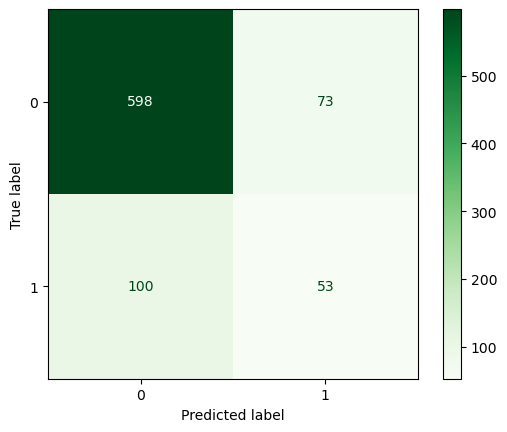

In [19]:
## Confusion Matrix for Score 1
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generating the confusion matrix  
cf_matrix = confusion_matrix(df.bad_transaction, df.risk_score1)

# where bad_transaction is the actual outcome and risk_score 1 is the predicted outcome

# Displaying the confusion matrix
ConfusionMatrixDisplay(cf_matrix).plot(cmap='Greens')
plt.show()

Remember, '1' is a bad transaction, i.e. "a positive" in the nomenclature. 

The matrix is read in the following way: 
- (1,1). True positives. The transaction was bad and the model predicted it as such. 53    
- (0,0). True negative. The transaction was good and the model predicted it as such. 598
- (0,1). False positive. The transaction was good but the model predicted it would be bad. 73 
- (1,0). False negative. The transaccion was bad, but the model predicted it would be good. 100

The first two are exactly what the model is supposed to screen. False positives would be opportunity costs: revenue not generated because of a stringent risk model. False negatives are unidentified losses by the model. These generate the losses. 
So the adequacy of the model for the purpose of the business is finding the right balance between these two quadrants. 

In [20]:
tn=598
fn=100
tp=53
fp=73
sum_all=824

Using these definitions, accuracy can be written as:

$$Accuracy = \frac{TN+TP}{TN+FP+FN+TP}$$

In [21]:
accu_score1= (tn + tp )/ sum_all

In [22]:
accu_score1

0.7900485436893204

Accuracy of score 1 is 79%

Precision measures what proportion of a model assigned to positive are actually members of the positive class:

$$Precision = \frac{TP}{TP+FP}$$

In [23]:
prec_score1=tp/(tp+fp)

In [24]:
prec_score1

0.42063492063492064

The model is not very precise. False positives are more than true positives. 

Recall measures how many members of the positive class the model correctly identified out of the total:

$$Recall = \frac{TP}{TP+FN}$$

In [25]:
rec_score1=tp/(tp+fn)

In [26]:
rec_score1

0.3464052287581699

Recall is lacking at 0.35. It classified 100 observations as false negatives, more than the true positives. 

### Profit

It the business only used this model, fp and tp would have not been accepted as transactions: 73+53 observations would have been labeled as risky. 

In [27]:
## Calculating the tn dataframe
tndf=df[(df['risk_score1']==0) & (df['bad_transaction']==0)]

In [28]:
tndf.shape

(598, 11)

Indeed it has 598 observations as in the confussion matrix. 

In [29]:
## Estimating revenue
Revenue_score1=0.05*(tndf['transaction'].sum())

In [30]:
Revenue_score1

2224.4500000000003

In [31]:
## Calculating the fn dataframe
fndf=df[(df['risk_score1']==0) & (df['bad_transaction']==1)]

In [32]:
## indeed the frame has 100 observations as in the confusion matrix
fndf.shape

(100, 11)

In [33]:
loss_score1=(fndf['transaction'].sum())

In [34]:
loss_score1

7654

In [35]:
Profit_score1=Revenue_score1-loss_score1

In [36]:
Profit_score1

-5429.549999999999

**Results for Model Score_1:**  

1. Accuracy: percentage of trues that the model gets correctly. score: 79%. Mediocre. 

2. Precision: measures what proportion of a model assigned to positive are actually members of the positive class. score: 42%. Not very precise. More false positives are more than true positives. 

3. Recall:  measures how many members of the positive class the model correctly identified out of the total. 35%. 
Not good. More false negatives than true positives. 

**Business metrics:**
- Income from good transactions: 2224.45
- Loss from bad transactions:   -7654
- **Net loss:                  -5429.55**

So by using the score from provider 1, the company has saved 3972 dollars (i.e. a smaller net loss) versus not using a score at all. However, they are still operating at a loss of 5429 dollars. The problem is that false negatives are very costly.

## Model 2: Credit Score 2

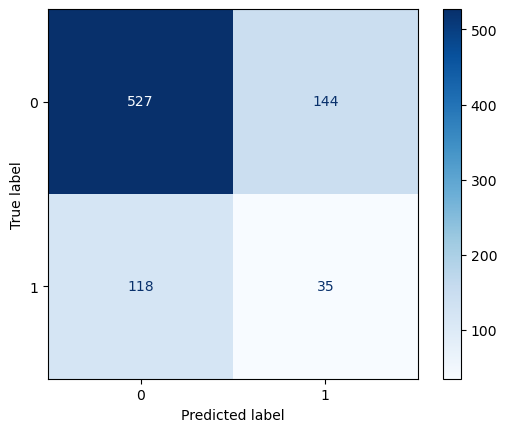

In [37]:
## Confusion Matrix for Score 2

# Generating the confusion matrix  
cf_matrix2 = confusion_matrix(df.bad_transaction, df.risk_score2)

# where bad_transaction is the actual score and risk_score 2 is the predicted score

# Displaying the confusion matrix
ConfusionMatrixDisplay(cf_matrix2).plot(cmap='Blues')
plt.show()

In [38]:
tn2=527
fn2=118
tp2=35
fp2=144
sum_all=824

In [39]:
accu_score2= (tn2 + tp2)/ sum_all

In [40]:
accu_score2

0.6820388349514563

Accuracy is lower than for model 1. 

In [41]:
prec_score2=tp2/(tp2+fp2)

In [42]:
prec_score2

0.19553072625698323

In [43]:
rec_score2=tp2/(tp2+fn2)

In [44]:
rec_score2

0.22875816993464052

**Results for Model Score_2:** 

1. Accuracy: percentage of trues that the model gets correctly. 68%. Bad.

2. Precision: measures what proportion of a model assigned to positive are actually members of the positive class. 20%. Very bad.

3. Recall:  measures how many members of the positive class the model correctly identified out of the total. 23%. Very bad. 

On all metrics, it is inferior to model 1. Hence, the loss will be worse. No need to calculate profit here.  
Estimations are done in the notebook. 

## Model 3: Interaction  of Score 1 & Score 2

In [45]:
df.interaction_1.sum()

42

In [52]:
df.interaction_2.sum()

323

Interaction_1 only has 42 positives. Considering there are 153 positives in the database. This does not bode well. No need to calculate profit here.  

Interaction_2  has 323 positives, so at least has a chance to catch all positives, but it's clear it will have a problem with false positives, as it doubles the amount of positives. It will reduce revenue for the company while overestimating risk. Let's conduct the exercise to calculate profits under this model. 

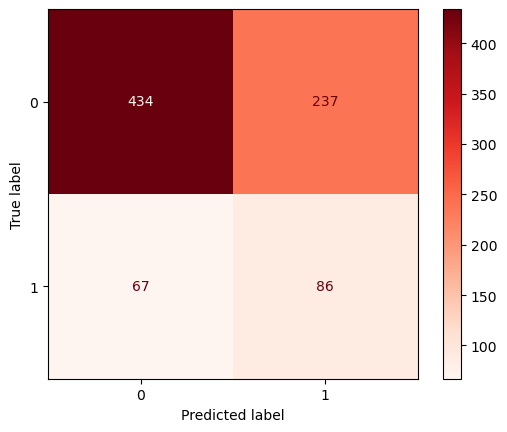

In [53]:
## Confusion Matrix for interaction term 2

# Generating the confusion matrix  
cf_matrix3 = confusion_matrix(df.bad_transaction, df.interaction_2)

# where bad_transaction is the actual score and interaction_2 is the predicted score

# Displaying the confusion matrix
ConfusionMatrixDisplay(cf_matrix3).plot(cmap='Reds')
plt.show()

As expected, false positives are an issue, and the model only catches a bit more then half of the true positives. 

In [54]:
tn3=434
fn3=67
tp3=86
fp3=237

In [55]:
accu_score3= (tn3 + tp3)/ sum_all
prec_score3=tp3/(tp3+fp3)
rec_score3=tp3/(tp3+fn3)

In [56]:
accu_score3

0.6310679611650486

In [57]:
prec_score3

0.26625386996904027

In [58]:
rec_score3

0.5620915032679739

In [59]:
## Calculating the tn dataframe
tndf3=df[(df['interaction_2']==0) & (df['bad_transaction']==0)]

In [60]:
tndf3.shape

(434, 11)

In [61]:
## Calculating the fn dataframe
fndf3=df[(df['interaction_2']==0) & (df['bad_transaction']==1)]

In [62]:
fndf3.shape

(67, 11)

In [63]:
## Estimating revenue
Revenue3=0.05*(tndf3['transaction'].sum())

In [64]:
Revenue3

1616.4

In [146]:
loss3=(fndf3['transaction'].sum())

In [147]:
loss3

5223

In [66]:
Profit3=Revenue3-loss3

In [67]:
Profit3

-3606.6

**Results for interaction_2 model**  

- Accuracy: percentage of trues that the model gets correctly. 63%. Bad.
- Precision: measures what proportion of a model assigned to positive are actually members of the positive class. 27%. Very bad.
- Recall: measures how many members of the positive class the model correctly identified out of the total. 56%. Bad, but better than the previous models. This might help mitigate the false negatives and avoid losses. 

**Business metrics:**  
- Income from good transactions: 1616.40
- Loss from bad transactions:   -5223
- **Net loss:                     -3606.60**

Total revenue takes a substantial hit from losing the false positive revenue. This is the best model so far, as the loss is smallest, USD 3607. This is because recall is the most important of the measures in terms for this particular business model. 

## Model 4: Logistic Regression

### Using Scikit Learn

The objective of this model is to improve on the profit of the previous scores. 
To use a logistic regression model with this data, I want to follow the next steps: 
- Separate features and target 
- Scale the data
- Optimize hyperparameters with k-fold validation
- Fit model
- Evaluate 

Since data is scarce, I will not be separating into the traditional train-test split. This is an ananlysis to help guide the company. With more data, and before taking the model to production, this could be done. 

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   score_1          824 non-null    object
 1   risk_score1      824 non-null    int64 
 2   score_2          824 non-null    object
 3   risk_score2      824 non-null    int64 
 4   interaction_1    824 non-null    int64 
 5   interaction_2    824 non-null    int64 
 6   transaction      824 non-null    int64 
 7   bad_transaction  824 non-null    int64 
 8   state            823 non-null    object
 9   population       824 non-null    int64 
 10  sc_control       824 non-null    int64 
dtypes: int64(8), object(3)
memory usage: 70.9+ KB


In [69]:
# Step 1: Separating the features and target
X = df.iloc[:, [1,3,4,5,6,9,10]]
y = df.iloc[:,7]

# adding an intercept
X = sm.add_constant(X)

In [71]:
X.head(3)

,const,risk_score1,risk_score2,interaction_1,interaction_2,transaction,population,sc_control
0,1.0,0,1,0,1,79,0,0
1,1.0,0,0,0,0,99,0,0
2,1.0,0,1,0,1,50,0,0


Most are dummies except for transaction amount. Hence, we'll need to scale. 

In [72]:
y

0      0
1      0
2      0
3      0
4      0
      ..
819    0
820    0
821    0
822    0
823    0
Name: bad_transaction, Length: 824, dtype: int64

In [73]:
## Additional libraries needed 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import random
np.random.seed(123)
random.seed(123)


In [74]:
## Step 2: Scaling the data

# create an instance
scaler = StandardScaler()

# fit to training set
scaler.fit(X)

# transform both train & test sets
X_scaled = scaler.transform(X)


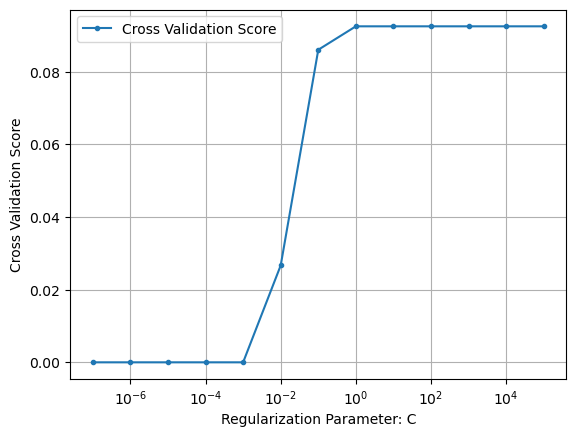

In [75]:
## Step 3: optimizing parameters with K-fold validation 
## I'm trying to maximize recall. As we saw earlier, this is the most relevant score for profit

cross_validation_scores = []

C_range = np.array([.0000001,.000001,.00001,.0001,.001,.01, .1, 1,10,100,1000,10000,100000])

#Do some cross validation
for c in C_range:
    LR_model = LogisticRegression(C=c,random_state=1)
    
    # the cross validation score (mean of scores from all folds)
    cv_score = np.mean(cross_val_score(LR_model, X_scaled, y, cv = 5, scoring='recall'))
    
    cross_validation_scores.append(cv_score)

plt.figure()
plt.plot(C_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

Numbers above 1 seem to be the best for maximizing recall. However, it's not very good. 

In [76]:
## Step 4: fit the model 

# 1. Instanitate model
logreg = LogisticRegression(random_state=1, C=1)

# fit to training sets
logreg.fit(X_scaled, y)

# make predictions for train and test sets
y_pred = logreg.predict(X_scaled)


[[646  25]
 [128  25]]


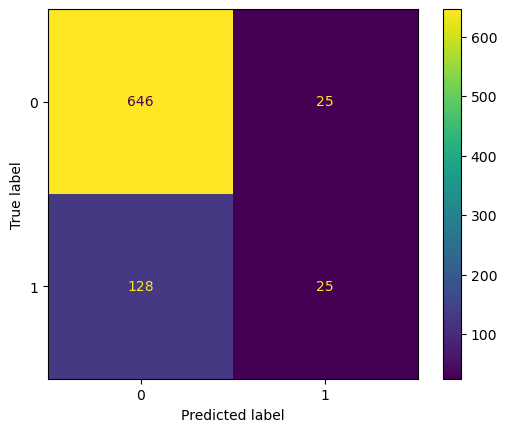

In [148]:
# Look at confusion matrix for training set
cm_val = confusion_matrix(y, y_pred)
print(cm_val)

# Use the nice display
ConfusionMatrixDisplay(cm_val).plot()

plt.show()

In [78]:
# classification report on the training data
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       671
           1       0.50      0.16      0.25       153

    accuracy                           0.81       824
   macro avg       0.67      0.56      0.57       824
weighted avg       0.77      0.81      0.77       824



The recall of this model is very bad. No need to calculate profits here. We have tried the scikit learn method, but we can also run the regression using the statsmodels api and setting the threshold differently, to reduce the number of false negatives. 

### Using the statsmodel API

In [79]:
## New library imported
import statsmodels.api as sm

In [80]:
# Instatiating
logreg2= sm.Logit(y, X)

# Fitting
logreg2_results = logreg2.fit()

# Priting the results
logreg2_results.summary()

Optimization terminated successfully.
         Current function value: 0.431485
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        bad_transaction   No. Observations:                  824
Model:                          Logit   Df Residuals:                      816
Method:                           MLE   Df Model:                            7
Date:                Wed, 19 Oct 2022   Pseudo R-squ.:                  0.1009
Time:                        11:34:47   Log-Likelihood:                -355.54
converged:                       True   LL-Null:                       -395.44
Covariance Type:            nonrobust   LLR p-value:                 1.525e-14
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.7026      0.455     -5.937      0.000      -3.595      -1.810
risk_score1       1.1610      0.263      4.408      0.000       0.645       1.677
risk_score2      -1.1091      0.328     -3.384      0.001      -1.751      -0.467
interaction_1     0.7902      0.494      1.599      0.110      -0.178       1.759
interaction_2     1.1309      0.220      5.137      0.000       0.699       1.562
transaction       0.0107      0.005      1.987      0.047       0.000       0.021
population       -0.2704      0.198     -1.369      0.171      -0.658       0.117
sc_control       -0.5507      0.415     -1.327      0.185      -1.364       0.263
=================================================================================
"""

Not all variables are statistically relevant, but we will keep them all to try to capture the greatest amount of variance. 

**Calculating odds ratios**

In [81]:
# defining the sigmoid curve manually
def sigmoid_curve(x):
    return 1 / (1 + np.exp(-x)) # exp(x) is the function to calculate e^x

In [82]:
logreg2_results.params 

const           -2.702559
risk_score1      1.161022
risk_score2     -1.109090
interaction_1    0.790201
interaction_2    1.130913
transaction      0.010729
population      -0.270434
sc_control      -0.550720
dtype: float64

**Explaining some of the coeficcients**

In [83]:
beta0 = logreg2_results.params[0]
beta1 = logreg2_results.params[1]
beta2 = logreg2_results.params[2]
beta3 = logreg2_results.params[3]
beta4 = logreg2_results.params[4]
beta5 = logreg2_results.params[5]
beta6 = logreg2_results.params[6]
beta7 = logreg2_results.params[7]

**For the constant**

In [84]:
np.exp(beta0)

0.06703372680294133

The odds of a transaction being bad are 0.06. Let's plug this into the sigmoid curve to get the probability. 

In [85]:
probability_of_badtransaction = sigmoid_curve(beta0)

In [86]:
probability_of_badtransaction

0.06282250046939804

The probability of a bad transaction according to this model is 0.06. Yet we know that 18% of the transactions are bad. 

**For risk score 1**

In [87]:
np.exp(beta1)

3.1931957214383577

If risk_score1 is 1, the odds of the transaction being bad increase 3.19 times

In [88]:
linear_combo=beta0+1*beta1

In [89]:
probability_of_badtransaction = sigmoid_curve(linear_combo)

In [90]:
probability_of_badtransaction

0.17631192336540896

By itself, if score1 is risky, the probability of being a bad transaction is 0.176. This is not an auspicious result. A lot of the variance is not being picked up by this score. 

**For risk score 2**

In [91]:
np.exp(beta2)

0.32985896157087574

If risk_score2 is 1, the odds increase to 0.32

In [92]:
linear_combo=beta0+1*beta2
probability_of_badtransaction = sigmoid_curve(linear_combo)
probability_of_badtransaction

0.021633326419382204

By itself, if score2 is risky, the probability of being a bad transaction is 0.02. Hence, score 2 does not tell us much by itself.

**For interaction term 1**

In [93]:
linear_combo=beta0+1*beta3
probability_of_badtransaction = sigmoid_curve(linear_combo)
probability_of_badtransaction

0.12871610247384355

By itself, if the interaction term considers the client risky, the probability of having a bad transaction is 0.129

**For the average size transaction**

In [94]:
linear_combo=beta0+75*beta5
probability_of_badtransaction = sigmoid_curve(linear_combo)
probability_of_badtransaction

0.13034741165325353

By itself, an average size transaction has a probability of 0.13 of being bad. 

In [95]:
##Grading the whole model. 
linear_combo=beta0+1*beta1+1*beta2+1*beta3+1*beta4+75*beta5+1*beta6+1*beta7
probability_of_badtransaction = sigmoid_curve(linear_combo)
probability_of_badtransaction

0.32169371789551177

For an average size transaction with all the risk markers on, the probability of it being bad is 0.32. Let see if we can fix the false negative problems by adjusting the threshold in the model towards this amount.  

In [96]:
## Getting the probability predictions for each observation 
model_predictions_prob=logreg2_results.predict(X)

In [97]:
## Setting the threshold at 0.5 and creating a binary predictions column
model_predictions_binary = np.where(model_predictions_prob>0.5,1,0)

In [98]:
model_predictions_binary.sum()

50

As we can see the model only predicts 50 bad transactions, when we know there are 157.If we decrease the thresold, it will tend to capture some more of those false negatives.  

The used threshold is 0.5
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       671
           1       0.50      0.16      0.25       153

    accuracy                           0.81       824
   macro avg       0.67      0.56      0.57       824
weighted avg       0.77      0.81      0.77       824

The used threshold is 0.45
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       671
           1       0.49      0.20      0.29       153

    accuracy                           0.81       824
   macro avg       0.67      0.58      0.59       824
weighted avg       0.78      0.81      0.78       824

The used threshold is 0.4
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       671
           1       0.48      0.21      0.29       153

    accuracy                           0.81       824
   macro avg       0.66      0.58      0.59      

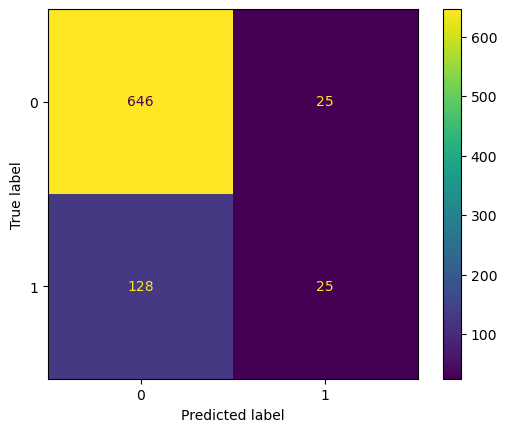

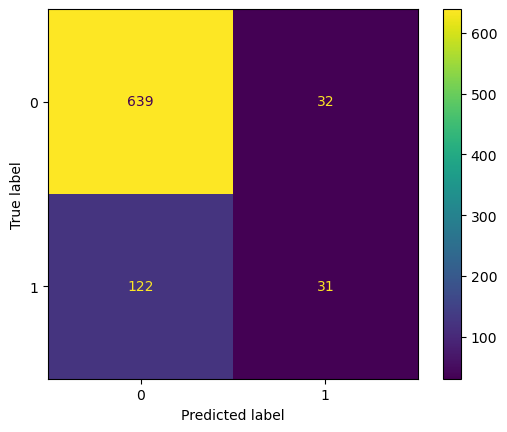

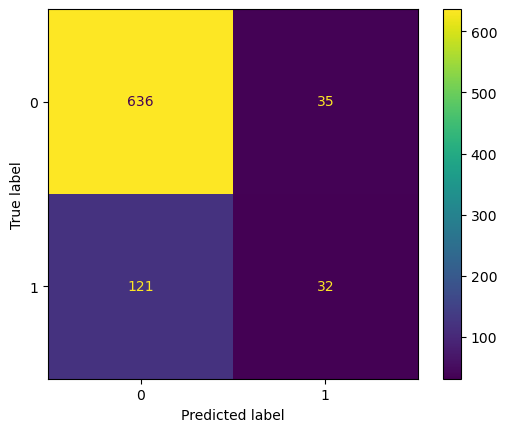

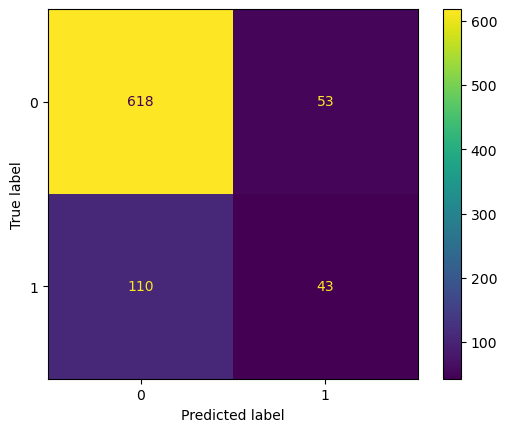

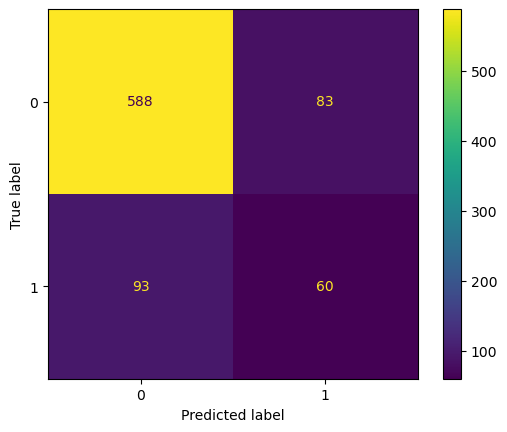

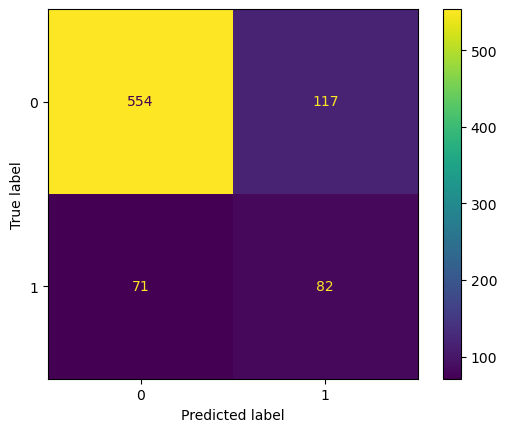

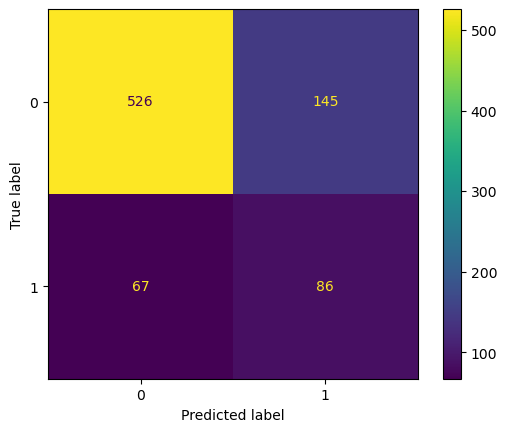

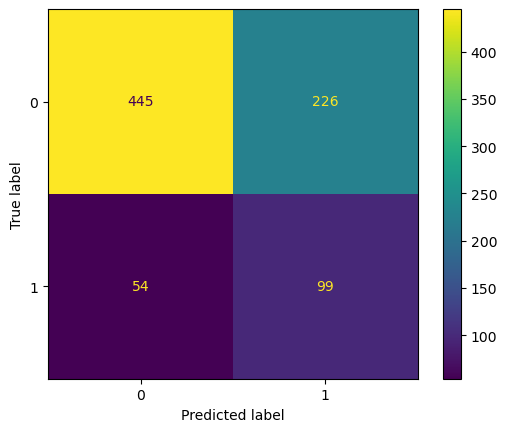

In [100]:
## creating a for loop to optimize the recall 
threshold=[0.50, 0.45, 0.40, 0.35,0.30, 0.25, 0.20, 0.15]

for i in threshold: 
    model_predictions_binary = np.where(model_predictions_prob>i,1,0)
    cm_val3 = confusion_matrix(y, model_predictions_binary)
    ConfusionMatrixDisplay(cm_val3).plot() 
    print(f'The used threshold is {i}')
    print(classification_report(y, model_predictions_binary))

Recall continues to increase as the threshold is lowered, though false positives are also going up. So losses are diminishing but so is revenue. Hence, the business side will have decide on this trade-off as false positives will alineate potential future customers. 

The threshold of 0.25 produces a similar recall to the interaction 1 model. Let's use that to estimate profits. 

#### Estimating profits for 0.25 threshold

The used threshold is 0.25
              precision    recall  f1-score   support

           0       0.89      0.83      0.85       671
           1       0.41      0.54      0.47       153

    accuracy                           0.77       824
   macro avg       0.65      0.68      0.66       824
weighted avg       0.80      0.77      0.78       824



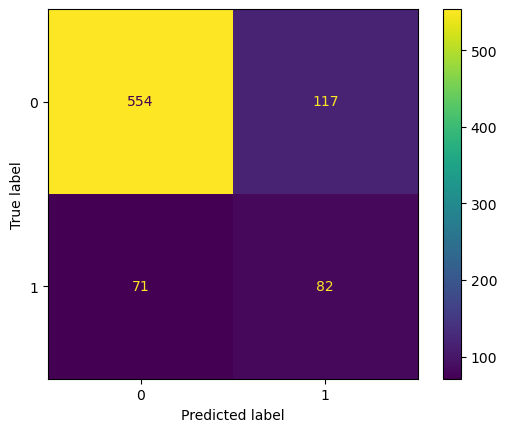

In [149]:
model_predictions_binary = np.where(model_predictions_prob>0.25,1,0)
cm_val3 = confusion_matrix(y, model_predictions_binary)
ConfusionMatrixDisplay(cm_val3).plot() 
print(f'The used threshold is 0.25')
print(classification_report(y, model_predictions_binary))

In [150]:
## incorporating the predictions in the dataframe for threshold 0.25
model_predictions_binary = np.where(model_predictions_prob>0.25,1,0)
df['predictions_log']=model_predictions_binary

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   score_1          824 non-null    object
 1   risk_score1      824 non-null    int64 
 2   score_2          824 non-null    object
 3   risk_score2      824 non-null    int64 
 4   interaction_1    824 non-null    int64 
 5   interaction_2    824 non-null    int64 
 6   transaction      824 non-null    int64 
 7   bad_transaction  824 non-null    int64 
 8   state            823 non-null    object
 9   population       824 non-null    int64 
 10  sc_control       824 non-null    int64 
 11  predictions_log  824 non-null    int32 
 12  predictions      824 non-null    int32 
 13  pred_prob_knn    824 non-null    int64 
 14  pred_prob_knn2   824 non-null    int64 
dtypes: int32(2), int64(10), object(3)
memory usage: 90.2+ KB


In [152]:
df.predictions_log.sum()

199

In [153]:
tndf4=df[(df['predictions_log']==0) & (df['bad_transaction']==0)]

In [154]:
tndf4.shape

(554, 15)

In [155]:
## Calculating the fn dataframe
fndf4=df[(df['predictions_log']==0) & (df['bad_transaction']==1)]

In [156]:
## Estimating revenue
Revenue4=0.05*(tndf4['transaction'].sum())

In [157]:
Revenue4

2032.3000000000002

In [158]:
loss4=(fndf4['transaction'].sum())

In [159]:
loss4

5317

In [160]:
Profit4=Revenue4-loss4

In [161]:
Profit4

-3284.7

**Business metrics:**  
- Income from good transactions: 2032
- Loss from bad transactions:   -5317
- **Net loss:                     -3284.70**

This is a better model than interaction_2, as the loss is smallest, USD 3284.70. Income is slightly better in this case, while losses are similar. 

## Model 5: KNN

In [162]:
from sklearn.neighbors import KNeighborsClassifier

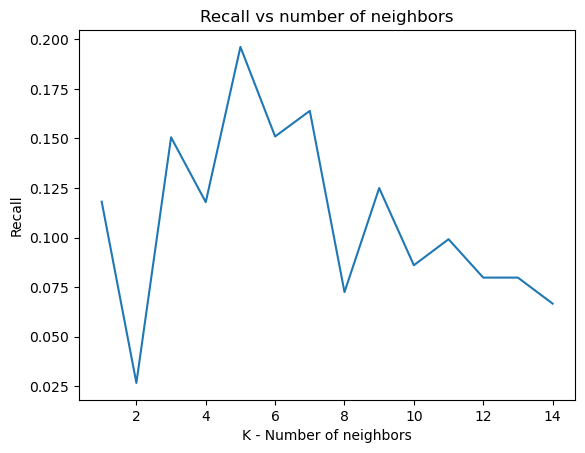

In [163]:
## K-folds cross validation for the Number of Neighbors parameter

# Define our list of k values to try out. We'll try 15 values. The dataset is small. 
k_values = list(range(1, 15,))

# Create a list to hold our cross-validation scores
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, scoring='recall', cv=5)
    cv_scores.append(np.mean(scores))
    
plt.figure()
plt.plot(k_values, cv_scores, label="mean score")
plt.xlabel('K - Number of neighbors')
plt.ylabel('Recall')
plt.title("Recall vs number of neighbors")
plt.show()    

The highest recall is achieved at 5 neighbors. We'll run the model with this parameter. 

In [164]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_scaled, y)

KNeighborsClassifier()

In [165]:
## generating predictions
y_pred_knn = knn.predict(X_scaled)

In [166]:
## including them in the df
df.loc[:,'pred_prob_knn']=y_pred_knn

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   score_1          824 non-null    object
 1   risk_score1      824 non-null    int64 
 2   score_2          824 non-null    object
 3   risk_score2      824 non-null    int64 
 4   interaction_1    824 non-null    int64 
 5   interaction_2    824 non-null    int64 
 6   transaction      824 non-null    int64 
 7   bad_transaction  824 non-null    int64 
 8   state            823 non-null    object
 9   population       824 non-null    int64 
 10  sc_control       824 non-null    int64 
 11  predictions_log  824 non-null    int32 
 12  predictions      824 non-null    int32 
 13  pred_prob_knn    824 non-null    int64 
 14  pred_prob_knn2   824 non-null    int64 
dtypes: int32(2), int64(10), object(3)
memory usage: 90.2+ KB


KNN estimation using 5 neighbors
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       671
           1       0.64      0.31      0.42       153

    accuracy                           0.84       824
   macro avg       0.75      0.64      0.66       824
weighted avg       0.82      0.84      0.82       824



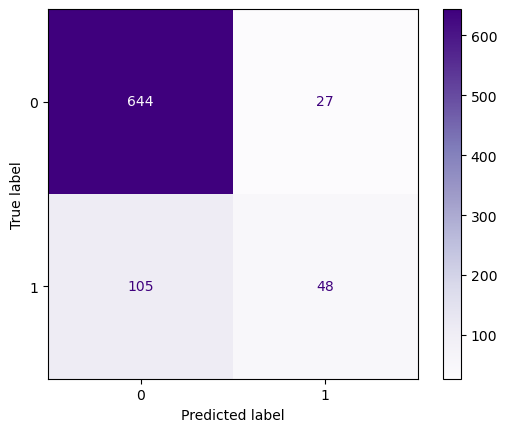

In [170]:
# generando la matriz de confusion 
cf_matrix = confusion_matrix(df.bad_transaction, df.pred_prob_knn)

# presentando la matriz
ConfusionMatrixDisplay(cf_matrix).plot(cmap='Purples')
print('KNN estimation using 5 neighbors')
print(classification_report(y, y_pred_knn))
plt.show()

The recall is inferior to previous alternatives.

In [171]:
tndf5=df[(df['pred_prob_knn']==0) & (df['bad_transaction']==0)]

In [172]:
tndf5.shape

(644, 15)

In [173]:
fndf5=df[(df['pred_prob_knn']==0) & (df['bad_transaction']==1)]

In [174]:
fndf5.shape

(105, 15)

In [175]:
Revenue5=0.05*(tndf5['transaction'].sum())

In [176]:
Revenue5

2380.5

In [177]:
loss5=(fndf5['transaction'].sum())

In [178]:
loss5

8032

In [140]:
Profit5=Revenue5-loss5

In [179]:
Profit5

-5651.5

This model is inferior to the previous ones. 

**Business metrics for KNN model:**

- Income from good transactions: 2380.5  
- Loss from bad transactions: -8032  
- **Net loss: -5651.5**

This is a worse model because of a lower recall. 

## Conclusion

- The company is losing money and needs to introduce some type of risk scoring system. 
- In terms of practicality, since the company is already paying for but not using Score 1 or Score 2, it should begin filtering clients using an interaction term of the two. The more stringent definition of risk diminishes net loss from 9400 dollars to 3607. This can be implemented right away so the company loses less money. 
- There are not enough observations yet to conduct a proper ML analysis with train and test sets. 
- Nevertheless, the logistic regression model using the Stats API does provide a smaller loss when the threshold for positivity is lowered to 0.25. The recall for this model is similar to that of interaction_2, yet it identifies more true negatives.  
- Overall, low accuracy, precision and recall are indicative of insuficient data, not just in quantity of observations but perhaps also in additional features to explain the target. 